In [62]:
#!pip install -U "langchain[anthropic]"
#!pip install langchain-community

In [63]:
from dotenv import load_dotenv
from langchain_anthropic import ChatAnthropic
import datetime
from datetime import timedelta

load_dotenv(dotenv_path="../.env", override=True)
model = ChatAnthropic(model='claude-3-sonnet')


In [64]:
import os
from langchain.chat_models import init_chat_model

api_key = os.getenv("ANTHROPIC_API_KEY")
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")

In [65]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import pandas as pd

In [66]:
import sys
# Make sure the 'agents' directory is in the Python path
# Adjust the path if your notebook is in a different location
sys.path.append('..') 

from agents.passenger_rebooking_agent import passenger_rebooking_agent

In [67]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect("../database/united_ops.db")

# Load full crew schedule including legality-related fields
mock_crew_schedule = pd.read_sql_query("""
    SELECT
        crew_id,
        name,
        assigned_flight,
        base,
        duty_start,
        duty_end,
        rest_hours_prior,
        last_flight_end,
        fatigue_score,
        role
    FROM crew
    WHERE duty_start IS NOT NULL AND duty_end IS NOT NULL
""", conn)

# Convert time fields to datetime
mock_crew_schedule[["duty_start", "duty_end", "last_flight_end"]] = mock_crew_schedule[
    ["duty_start", "duty_end", "last_flight_end"]
].apply(pd.to_datetime)

conn.close()

print(mock_crew_schedule.head())


     crew_id    name assigned_flight base          duty_start  \
0  DL7016_C0  Crew_0          DL7016  ORD 2025-06-25 03:56:00   
1  DL7016_C1  Crew_1          DL7016  ORD 2025-06-25 03:56:00   
2  DL7016_C2  Crew_2          DL7016  ORD 2025-06-25 03:56:00   
3  DL7016_C3  Crew_3          DL7016  ORD 2025-06-25 03:56:00   
4  DL7016_C4  Crew_4          DL7016  ORD 2025-06-25 03:56:00   

             duty_end  rest_hours_prior     last_flight_end  fatigue_score  \
0 2025-06-25 07:36:00                10 2025-06-24 17:56:00            1.4   
1 2025-06-25 07:36:00                10 2025-06-24 17:56:00            1.4   
2 2025-06-25 07:36:00                10 2025-06-24 17:56:00            1.4   
3 2025-06-25 07:36:00                10 2025-06-24 17:56:00            1.4   
4 2025-06-25 07:36:00                10 2025-06-24 17:56:00            1.4   

        role  
0      Pilot  
1  Attendant  
2  Attendant  
3  Attendant  
4  Attendant  


### Shared agent state definition

In [68]:

from typing import Annotated, TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
import pandas as pd
from operator import add

class SystemState(TypedDict):
    proposals: Annotated[List[Dict[str, Any]], add]
    crew_schedule: pd.DataFrame
    passenger_itinerary: pd.DataFrame
    legality_flags: Annotated[List[str], add]
    crew_substitutions: Dict[str, List[str]]
    current_flight_crews: Dict[str, List[str]]
    messages: Annotated[List[str], add]
    iteration_count: int
    plan_summary: str
    final_plan: Dict[str, Any]
    # New fields for passenger rebooking
    flight_cancellation_notification: Dict[str, Any]  # Optional
    impacted_passengers: pd.DataFrame  # Optional
    alternative_flights: pd.DataFrame  # Optional
    assignment_summary: Dict[str, Any]  # Optional
    rebooking_proposals: List[Dict[str, Any]]  # Optional

### Crew Ops Agent

In [69]:
from typing import List, Dict, Any
import pandas as pd
import sqlite3
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_anthropic import ChatAnthropic
from langchain.prompts import ChatPromptTemplate

# Constants
MAX_DUTY_HOURS = 10
MIN_REST_HOURS = 10
MAX_FATIGUE_SCORE = 1.0

@tool
def check_legality_tool(crew_schedule: List[Dict[str, Any]]) -> List[str]:
    """
    FAA legality check.
    Expects a flat list of crew members with keys:
    - assigned_flight
    - duty_start, duty_end
    - rest_hours_prior
    - fatigue_score
    If input is nested, it will be flattened.
    """
    # Handle nested input
    if all("crew" in item and "flight_id" in item for item in crew_schedule):
        flat_crew = []
        for flight in crew_schedule:
            for crew in flight["crew"]:
                crew["assigned_flight"] = flight["flight_id"]
                flat_crew.append(crew)
        crew_schedule = flat_crew

    df = pd.DataFrame(crew_schedule)

    required_cols = ["assigned_flight", "duty_start", "duty_end", "rest_hours_prior", "fatigue_score"]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required fields: {missing_cols}")

    violations = []
    for flight_id, group in df.groupby("assigned_flight"):
        for _, row in group.iterrows():
            duty_hours = (pd.to_datetime(row["duty_end"]) - pd.to_datetime(row["duty_start"])) / pd.Timedelta(hours=1)
            if duty_hours > MAX_DUTY_HOURS or row["rest_hours_prior"] < MIN_REST_HOURS or row["fatigue_score"] > MAX_FATIGUE_SCORE:
                violations.append(flight_id)
                break
    return list(set(violations))


@tool
def get_unassigned_crew_from_db(input: Dict[str, Any] = {}) -> List[Dict[str, Any]]:
    """
    Pulls unassigned crew directly from the SQLite database.
    Can be invoked with no parameters.

    Crew must have:
    - No current flight assignment (assigned_flight IS NULL)
    - Rest hours >= MIN_REST_HOURS
    - Fatigue score <= MAX_FATIGUE_SCORE
    """
    conn = sqlite3.connect("../database/united_ops.db")
    query = """
        SELECT crew_id, name, base, rest_hours_prior, fatigue_score, role
        FROM crew
        WHERE assigned_flight IS NULL
          AND rest_hours_prior >= ?
          AND fatigue_score <= ?
    """
    df = pd.read_sql_query(query, conn, params=(MIN_REST_HOURS, MAX_FATIGUE_SCORE))
    conn.close()
    return df.to_dict(orient="records")

@tool
def propose_substitutes_tool(violations: List[str], crew_schedule: List[Dict[str, Any]], unassigned_crew: List[Dict[str, Any]]) -> Dict[str, List[str]]:
    """
        Propose legal substitute crew members for flights that violate FAA rules.

        Input:
        - `violations` (list): A list of FAA violation entries. Each violation should reference a flight_id and the affected crew. Violations can be obtained from `check_legality_tool and have a structure of list of flight IDs that have violations.
        - `crew_schedule` (list): The current full crew schedule, with each entry containing fields like `crew_id`, `assigned_flight`, `role`, `base`, `fatigue_score`, and other relevant attributes.
        - `unassigned_crew` (list): A list of available crew members not currently assigned to a flight. Each must include:
            - `crew_id` (str)
            - `role` (str) — either "Pilot" or "Attendant"
            - `base` (str)
            - `fatigue_score` (float between 0 and 1)
            - optionally: `rest_hours_prior`, `last_flight_end`, etc.

        Usage:
        1. Always call `get_unassigned_crew_from_db` before using this tool.
        2. Ensure the unassigned crew have matching `role` and `base` to the affected crew in violations.
        3. The tool will match substitutes by lowest fatigue and highest availability.

        Output:
        - Returns a dictionary mapping `flight_id` to a list of proposed new crew assignments.
    """
    df = pd.DataFrame(crew_schedule)
    unassigned = pd.DataFrame(unassigned_crew)
    substitutions = {}
    for flight_id in violations:
        needed_roles = df[df["assigned_flight"] == flight_id]["role"].value_counts()
        crew_ids = []
        for role, count in needed_roles.items():
            eligible = unassigned[unassigned["role"] == role]
            selected = eligible.head(count)
            crew_ids.extend(selected["crew_id"].tolist())
            unassigned = unassigned[~unassigned["crew_id"].isin(selected["crew_id"])]
        substitutions[flight_id] = crew_ids
    return substitutions


@tool
def get_full_schedule_from_db(_: Dict[str, Any]) -> List[Dict[str, Any]]:
    """
    Pulls the entire current crew schedule from the SQLite database,
    including assigned_flight, duty_start, fatigue_score, and other FAA-relevant fields.
    """
    conn = sqlite3.connect("../database/united_ops.db")
    df = pd.read_sql_query("""
        SELECT
            crew_id, name, assigned_flight, base, duty_start, duty_end,
            rest_hours_prior, last_flight_end, fatigue_score, role
        FROM crew
        WHERE duty_start IS NOT NULL AND duty_end IS NOT NULL
    """, conn)
    conn.close()
    df[["duty_start", "duty_end", "last_flight_end"]] = df[["duty_start", "duty_end", "last_flight_end"]].apply(pd.to_datetime)
    return df.to_dict(orient="records")


def crew_ops_anthropic_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    print("🧑‍✈️ Claude CrewOpsAgent activated")
    state.setdefault("messages", []).append("Claude CrewOpsAgent analyzing FAA legality")

    llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.1)
    tools = [check_legality_tool, get_unassigned_crew_from_db, propose_substitutes_tool]
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", 
        "You are a flight legality compliance agent.\n"
        "Step 1: Use `get_full_schedule_from_db` to load the crew schedule.\n"
        "Step 2: Use `check_legality_tool` to identify FAA violations.\n"
        "Step 3: Use `get_unassigned_crew_from_db` to get replacement candidates.\n"
        "Step 4: Use `propose_substitutes_tool` with the violations, crew schedule, and unassigned crew.\n"
        "If `unassigned_crew` is missing, re-run `get_unassigned_crew_from_db`.\n"
        "You must call `propose_substitutes_tool` with all required fields."),
        ("user", "{input}"),
        ("ai", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    # Log current schedule
    crew_schedule_df = state["crew_schedule"]
    print("🧪 Crew schedule columns:", crew_schedule_df.columns.tolist())
    print("🧪 Crew schedule sample:", crew_schedule_df.head())

    try:
        result = agent_executor.invoke({
            "input": "Begin compliance review using FAA rules. Load crew schedule from the database and resolve any violations."
        })

        # If output is not a dict, extract it safely
        if isinstance(result, dict):
            substitutions = result
        else:
            substitutions = result.get("output", {})

    except Exception as e:
        print(f"⚠️ Initial attempt failed: {e}")
        state.setdefault("messages", []).append(f"CrewOpsAgent: Initial tool call failed, retrying manually")

        # Manual fallback
        try:
            # Retry: Run legality and substitutions directly
            crew_schedule = get_full_schedule_from_db({})
            violations = check_legality_tool(crew_schedule)
            unassigned_crew = get_unassigned_crew_from_db({})
            substitutions = propose_substitutes_tool(violations=violations, crew_schedule=crew_schedule, unassigned_crew=unassigned_crew)

        except Exception as e2:
            print(f"❌ Fallback also failed: {e2}")
            state.setdefault("messages", []).append("CrewOpsAgent failed to resolve substitutions")
            return state

    for flight_id, crew_list in substitutions.items():
        state.setdefault("crew_substitutions", {})[flight_id] = crew_list
        if crew_list:
            state.setdefault("current_flight_crews", {})[flight_id] = crew_list
            state.setdefault("messages", []).append(f"CrewOpsAgent: Substituted crew for flight {flight_id}")
            state.setdefault("proposals", []).append({
                "agent": "CrewOpsAgent",
                "flight": flight_id,
                "action": "Substitution",
                "reason": "FAA violation",
                "crew": crew_list
            })
        else:
            state.setdefault("messages", []).append(f"CrewOpsAgent: No substitute available for flight {flight_id}")

    state.setdefault("legality_flags", []).extend(list(substitutions.keys()))
    state["messages"].append("Claude CrewOpsAgent completed analysis")
    return state



c:\Users\sveldman\AppData\Local\anaconda3\Lib\site-packages\pydantic\main.py:1522: RuntimeWarning: fields may not start with an underscore, ignoring "_"
  warnings.warn(f'fields may not start with an underscore, ignoring "{f_name}"', RuntimeWarning)


### PlannerAgent Node

In [70]:
from langchain.tools import tool
from langchain_anthropic import ChatAnthropic
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.prompts import ChatPromptTemplate
from typing import Dict, Any

@tool
def read_messages_tool(state: Dict[str, Any]) -> str:
    """
    Reads and summarizes all system messages from the langgraph state.
    Returns a chronological log of all agent activities and messages.
    """
    messages = state.get("messages", [])
    if not messages:
        return "No messages found in system state."
    return "\n".join(f"- {msg}" for msg in messages)

def planner_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    print("🧠 Enhanced PlannerAgent activated")

    llm = ChatAnthropic(model="claude-3-5-sonnet-latest", temperature=0.3)
    tools = [read_messages_tool]

    prompt = ChatPromptTemplate.from_messages([
        ("system", 
         "You are an executive planner summarizing operational activity.\n"
         "Use `read_messages_tool` to access the system-wide activity log.\n"
         "Then provide a clear executive summary that includes:\n"
         "- Major actions taken by agents\n"
         "- Any remaining issues or risks\n"
         "- Recommended next steps or resolutions."),
        ("user", "{input}"),
        ("ai", "{agent_scratchpad}")
    ])

    agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

    result = agent_executor.invoke({
        "input": "Generate an executive-level summary of all actions and changes from system agents.",
        "state": state
    })

    summary_text = result.get("output", "No summary generated.")
    state["plan_summary"] = summary_text
    state.setdefault("messages", []).append("Enhanced PlannerAgent generated executive summary.")

    return state


## Passenger Rebooking Agent

In [71]:
# --- Standalone Agent Test ---

# 1. Define the database path relative to the notebook's location
DB_PATH = "../database/united_ops.db"

# 2. Create a sample flight cancellation notification
test_cancellation = {
    "flight_number": "DL7016",
    "arrival_location": "ORD", 
    "arrival_time": "2025-06-25 07:36:00"
}

# 3. Create an initial state for the test
initial_state = {
    "proposals": [],
    "flight_cancellation_notification": test_cancellation,
    "impacted_passengers": None,
    "alternative_flights": None,
    "assignment_summary": None,
    "rebooking_proposals": None
}

# 4. Call the agent function directly, passing the state and db_path
print("--- Running Standalone Agent Test ---")
result_state = passenger_rebooking_agent(initial_state, db_path=DB_PATH)
print("--- Test Complete ---\\n")

# 5. Print a summary of the results
summary = result_state.get('assignment_summary')
if summary:
    print("📊 Assignment Summary:")
    print(f"  - Assignment Rate: {summary.get('assignment_rate', 0):.1f}%")
    print(f"  - Passengers Assigned: {summary.get('passengers_assigned', 0)} / {summary.get('total_passengers', 0)}")
    print(f"  - Flights Used: {summary.get('flights_used', 0)}\\n")

    # Display a few rebooking proposals
    proposals = result_state.get('rebooking_proposals', [])
    if proposals:
        print("📄 Sample Rebooking Proposals:")
        for proposal in proposals[:3]: # Print first 3 proposals
            passenger = proposal.get('passenger_id')
            new_flight = proposal.get('rebooked_flight')
            print(f"  - Passenger {passenger} rebooked on flight {new_flight}")
else:
    print("No assignment summary found in the result state.")

--- Running Standalone Agent Test ---
🧑‍💼 PassengerRebookingAgent activated
🚨 Flight cancellation detected: DL7016 to ORD
📊 Found 27 impacted passengers
Impacted passengers preview:
  passenger_id loyalty_tier new_flight
0    DL7016_P0           1K           
1    DL7016_P1        Basic           
2    DL7016_P2        Basic           
3    DL7016_P3        Basic           
4    DL7016_P4        Basic           
✈️ Found 49 alternative flights to ORD
Alternative flights preview:
  flight_number departure_location      departure_time        arrival_time  \
0         SW111                JFK 2025-06-25 09:33:00 2025-06-25 12:25:00   
1        DL7395                JFK 2025-06-25 18:25:00 2025-06-25 23:16:00   
2        AA8859                JFK 2025-06-26 06:35:00 2025-06-26 08:50:00   
3        JB9256                JFK 2025-06-26 18:31:00 2025-06-26 22:56:00   
4        SW5239                JFK 2025-06-26 21:23:00 2025-06-26 22:27:00   

      status  available_seats  
0    delayed   

## DispatchOpsAgent

In [72]:

def has_legality_violations(state: Dict[str, Any]) -> bool:
    """
    Checks for legality violations flagged by CrewOpsAgent.
    """
    return bool(state.get("legality_flags"))

# Checkk if all crew members are legal to fly based on the mock crew schedule for a given flight 

def detect_fuel_capacity(DepartureFuel: Dict[str, Any]) -> Dict[str, str]:
    """
    Checks fuel readiness before dispatch using keys:
    'FUEL ORDER' or 'FUEL FINAL'
    """
    if "FUEL FINAL" in DepartureFuel:
        return {}
    if "FUEL ORDER" in DepartureFuel:
        return {"FUEL_REQUESTED": "Airplane needs fuel prior to departure."}
    return {"FUEL_DATA_MISSING": "No fuel data provided: both FUEL ORDER and FUEL FINAL are missing."}

def detect_weather_risks(DepartureWeather: Dict[str, str]) -> Dict[str, str]:
    """
    Detects weather-related risks at the departure location from METAR codes.
    """
    metar = DepartureWeather.get("departure", "")
    delay_codes = {
        "TS": "Thunderstorm in vicinity (delay expected)",
        "FG": "Fog reported (delay expected)",
        "SN": "Snow present at departure (delay expected)",
    }
    return {code: msg for code, msg in delay_codes.items() if code in metar}

def dispatch_ops_agent(state: Dict[str, Any]) -> Dict[str, Any]:
    """
    LangGraph-compatible DispatchOpsAgent.
    Evaluates legality, fuel, and weather for dispatch readiness.
    """
    print("🛰️ DispatchOpsAgent activated")
    state.setdefault("messages", []).append("DispatchOpsAgent checking dispatch readiness")

    violations = {}

    # Check crew legality
    if has_legality_violations(state):
        violations["CREW_LEGALITY"] = "One or more flights have FAA legality violations."

    # Check weather risks
    violations.update(detect_weather_risks(state.get("weather_data", {}))) ## change to weather MCP

    # Check fuel readiness
    violations.update(detect_fuel_capacity(state.get("fuel_data", {})))

    # Final decision
    status = "EXCEPTION" if violations else "GREEN"
    message = (
        "DispatchOpsAgent found dispatch violations."
        if violations else "DispatchOpsAgent approved dispatch readiness."
    )
    state["messages"].append(message)

    return {
        **state,
        "dispatch_status": status,
        "dispatch_violations": violations,
    }



### Graph Assembly

In [73]:
# Passenger Rebooking Node Helper Functions

# Define the database path relative to the notebook's location
DB_PATH = "../database/united_ops.db"

def passenger_rebooking_node(state: SystemState) -> SystemState:
    """Wrapper to call the passenger rebooking agent with the correct db path."""
    # The passenger_rebooking_agent is imported from the .py file
    # We pass the db_path to it here.
    return passenger_rebooking_agent(state, db_path=DB_PATH)

# Conditional Logic to Decide if the Rebooking Agent Should Run
def should_run_rebooking(state: SystemState) -> str:
    """Conditional logic to decide if the rebooking agent should run."""
    if state.get("flight_cancellation_notification"):
        return "passenger_rebooking_agent"
    else:
        # If there's no cancellation, you can route to another agent or end
        return "planner_agent" # or "__end__"

In [84]:
from langgraph.graph import StateGraph, END

# Create sequential graph with planner coming last
graph = StateGraph(SystemState)

# Add nodes
graph.add_node("crew_ops", crew_ops_anthropic_agent)
graph.add_node("passenger_rebook", passenger_rebooking_node)
graph.add_node("dispatch_ops", dispatch_ops_agent)
graph.add_node("planner", planner_agent)
workflow = StateGraph(SystemState)

# Define flow
workflow.set_entry_point("CrewOpsAgent")
workflow.add_edge("CrewOpsAgent", "PlannerAgent")
workflow.add_edge("PlannerAgent", END)


# Define execution order: crew_ops -> passenger_rebook -> dispatch_ops -> planner
#graph.set_entry_point("crew_ops")
#graph.add_edge("crew_ops", "passenger_rebook")
#graph.add_edge("passenger_rebook", "dispatch_ops")
#graph.add_edge("dispatch_ops", "planner")

# Alternative execution order: passenger_rebook -> dispatch_ops -> crew_ops -> planner
graph.set_entry_point("passenger_rebook")
graph.add_edge("passenger_rebook", "dispatch_ops")
graph.add_edge("dispatch_ops", "crew_ops")
graph.add_edge("crew_ops", "planner")

# Set end point
graph.set_finish_point("planner")

# Compile graph
plan_executor = graph.compile()

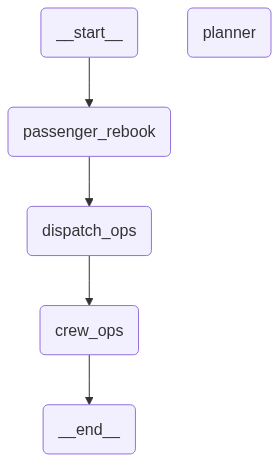

In [85]:
from IPython.display import Image, display

png = plan_executor.get_graph().draw_mermaid_png()
display(Image(png))

In [ ]:
test_cancellation = {
    "flight_number": "DL7016",
    "arrival_location": "ORD", 
    "arrival_time": "2025-06-25 07:36:00"
}

# 3. Create an initial state for the test
initial_state = {
    "proposals": [],
    "flight_cancellation_notification": test_cancellation,
    "impacted_passengers": None,
    "alternative_flights": None,
    "assignment_summary": None,
    "rebooking_proposals": None
}


# Initialize state with additional fields for enhanced functionality
initial_state = {
    "proposals": [],
    "crew_schedule": mock_crew_schedule,
    "flight_crew_mapping": {},      # For crew tracking
    "crew_substitutions": {},       # For substitution tracking
    "current_flight_crews": {},     # For current assignments
    "legality_flags": [],           # For compliance tracking
    "messages": [],                 # For message tracking
    "iteration_count": 0,           # For iteration tracking
    "weather_data": {},             # For dispatch ops
    "fuel_data": {},                 # For dispatch ops
    "flight_cancellation_notification": test_cancellation,
    "impacted_passengers": None,
    "alternative_flights": None,
    "assignment_summary": None,
    "rebooking_proposals": None
}

print("🚀 Starting Multi-Agent Airline Operations Analysis...")
print("=" * 60)

# Execute the multi-agent system
output = plan_executor.invoke(initial_state)

print("=" * 60)
print("✅ Analysis Complete!")
print("=" * 60)

🚀 Starting Multi-Agent Airline Operations Analysis...
🧑‍💼 PassengerRebookingAgent activated
🚨 Flight cancellation detected: DL7016 to ORD
📊 Found 27 impacted passengers
Impacted passengers preview:
  passenger_id loyalty_tier new_flight
0    DL7016_P0           1K           
1    DL7016_P1        Basic           
2    DL7016_P2        Basic           
3    DL7016_P3        Basic           
4    DL7016_P4        Basic           
✈️ Found 49 alternative flights to ORD
Alternative flights preview:
  flight_number departure_location      departure_time        arrival_time  \
0         SW111                JFK 2025-06-25 09:33:00 2025-06-25 12:25:00   
1        DL7395                JFK 2025-06-25 18:25:00 2025-06-25 23:16:00   
2        AA8859                JFK 2025-06-26 06:35:00 2025-06-26 08:50:00   
3        JB9256                JFK 2025-06-26 18:31:00 2025-06-26 22:56:00   
4        SW5239                JFK 2025-06-26 21:23:00 2025-06-26 22:27:00   

      status  available_seats  